In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import splev, splrep
from scipy.io import loadmat
from scipy.signal import kaiserord, firwin, lfilter
import scipy.io as sio
import os
from scipy.io import loadmat
import random
import scipy
import json
from scipy.signal import welch
import math
import sklearn.preprocessing
import sklearn
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import norm
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# 0.5 FUNCTION DEFINITION

In [3]:
def hyper_parameters_search_c(clf,train_set, param_grid, scorer = 'accuracy', cv=5):
    results_list = []
    param_list = []
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = "accuracy")
    for validation in range(0, cv):
        train_train_set, val_set = cross_val_automated(train_set) #FUNCIÓN DE OBTENER TRAIN Y VALIDATION
        X_train = train_train_set.iloc[:, [3,5,6,7]]
        y_train = train_train_set.iloc[:,4]
        y_train = y_train.astype(int)
        grid.fit(X_train, y_train)
        results_list.append(grid.best_score_)
        param_list.append(grid.best_params_)
    return results_list, param_list
# These are customized functions: should be in utils.py
def hyper_parameters_search(clf, X, y, param_grid, scorer = 'f1', cv=5):
    
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = scorer, cv = cv)
    grid.fit(X, y)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))
    
    return grid

def plot_cv_scoring(grid, hyper_parameter, scorer, plot_errors = False, log=False):
    
    scores = np.array(grid.cv_results_['mean_test_score'])

    std_scores = grid.cv_results_['std_test_score']
        
    params = grid.param_grid[hyper_parameter]
    print(params)

    
    if log:
        params = np.log10(params)
    
    if plot_errors:
        plt.errorbar(params,scores,yerr=std_scores, fmt='o-',ecolor='g')
    else:
        print(len(params))
        print(len(scores))
        print(scores)
        plt.plot(params,scores, 'o-')
    plt.title("Results for each" + hyper_parameter +"value in " + scorer)
    plt.xlabel(hyper_parameter,fontsize=14)
    plt.ylabel(scorer)
    plt.show()
def plot_variance_threshold(X_train, variances, threshold, feature_names):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(variances)), variances, color='blue', label='Variance')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Variance threshold')
    plt.xticks(range(len(variances)), [f"{i}"for i in feature_names])
    plt.xticks(rotation='vertical')
    plt.title('Variance of each feature with the threshold')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    plt.legend()
    plt.show()

from sklearn.metrics import confusion_matrix, roc_curve, auc

def get_metrics(confmat):
    '''Unravel confusion matrix and calculate performance metrics'''
    tn, fp, fn, tp = confmat.ravel()
    
    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv)/(sen+ppv)
    
    return acc, sen, esp, ppv, fsc
    
def print_performance_metrics(confmat_train, *confmat_test):
    '''Print performance metrics'''
    
    if not confmat_test:
        acc, sen, esp, ppv, fsc = get_metrics(confmat_train)
        print('ACC: %2.2f' %(100*acc))
        print('SEN: %2.2f' %(100*sen))
        print('ESP: %2.2f' %(100*esp))
        print('PPV: %2.2f' %(100*ppv))
        print('F1: %2.2f' %(100*fsc))
    else:
        acc_train, sen_train, esp_train, ppv_train, fsc_train = get_metrics(confmat_train)
        acc_test, sen_test, esp_test, ppv_test, fsc_test = get_metrics(confmat_test[0])
        metrics = [acc_train, sen_train, esp_train, ppv_train, fsc_train,acc_test, sen_test, esp_test, ppv_test, fsc_test]
        
        print('PERFORMANCE METRICS')
        print('\tTRAIN\tTEST')
        print('ACC:\t%2.2f\t%2.2f' %(100*acc_train, 100*acc_test))
        print('SEN:\t%2.2f\t%2.2f' %(100*sen_train, 100*sen_test))
        print('ESP:\t%2.2f\t%2.2f' %(100*esp_train, 100*esp_test))
        print('PPV:\t%2.2f\t%2.2f' %(100*ppv_train, 100*ppv_test))
        print('F1:\t%2.2f\t%2.2f'  %(100*fsc_train, 100*fsc_test))
        
        return metrics
        
def plot_roc_curve(y,y_prob):
    
    '''Plot ROC-AUC Curve and target probability'''
    
    ejex, ejey, _ = roc_curve(y, y_prob)
    roc_auc = auc(ejex, ejey)

    plt.figure(figsize = (12,4))
    
    # ROC-AUC CURVE
    plt.subplot(1,2,1)
    plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Perfect classifier')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR (1-ESP)')
    plt.ylabel('SEN')
    plt.legend(loc="lower right")
    
    # PROB DENSITY 
    idx_0 = (y==0)
    idx_1 = (y==1)
    
    plt.subplot(1,2,2)
    plt.hist(y_prob[idx_0],density=1,bins = 20, label='y=0',alpha=0.5)
    plt.hist(y_prob[idx_1],density=1,bins = 20, facecolor='red',label='y=1',alpha=0.5)
    plt.legend()
    plt.xlabel('target probability')
    
    plt.show()
    return roc_auc

def plot_confusion_matrix(confmat_train, *confmat_test):
    ''' Plot confusion matrix
        - A single confusion matrix
        - Comparing two confusion matrices, if provided
    '''
    
    if not confmat_test:
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_train.shape[0]):
            for j in range(confmat_train.shape[1]):
                ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

        plt.xlabel('predicted label')
        plt.ylabel('true label')

        plt.tight_layout()
        plt.show()
        
    else:
        fig, ax = plt.subplots(1,2,figsize=(6, 6))
        ax[0].matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_train.shape[0]):
            for j in range(confmat_train.shape[1]):
                ax[0].text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

        ax[1].matshow(confmat_test[0], cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_test[0].shape[0]):
            for j in range(confmat_test[0].shape[1]):
                ax[1].text(x=j, y=i, s=confmat_test[0][i, j], va='center', ha='center')
    
        ax[0].set_xlabel('predicted label')
        ax[0].set_ylabel('true label')
        ax[0].set_title('TRAIN')
        
        ax[1].set_xlabel('predicted label')
        ax[1].set_ylabel('true label')
        ax[1].set_title('TEST')

        plt.tight_layout()
        plt.show()

def analyze_train_test_performance(clf, X_train, X_test, y_train, y_test):
    
    '''Analyze Train and Test Performance'''
    
    # get predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)
    
    # get confusion matrices
    confmat_train = confusion_matrix(y_train, y_pred_train)
    confmat_test  = confusion_matrix(y_test, y_pred_test)
    
    # Plot confusion matrices and provide metrics
    metrics = print_performance_metrics(confmat_train, confmat_test)
    plot_confusion_matrix(confmat_train, confmat_test)

    # Plot ROC curve
    y_prob = clf.predict_proba(X_test)[:,1]
    print(type(y_prob))
    roc_auc = plot_roc_curve(y_test,y_prob)
    
    return metrics, roc_auc
    
def crossval_curves(model, X, y, param_name, scorer, param_range):
    train_scores, validation_scores = validation_curve(model, X, y, param_name=param_name, scoring=scorer, param_range=param_range)

    # Plot the mean train error and validation error across folds
    plt.figure(figsize=(6, 4))
    plt.plot(param_range, validation_scores.mean(axis=1), lw=2, label='Validation', marker='o')
    plt.plot(param_range, train_scores.mean(axis=1), lw=2, label='Train',marker='*')
    plt.legend(loc='best')
    plt.xlabel(param_name)
    plt.ylabel(scorer)
    plt.title('Validation curve')
    plt.tight_layout()
    plt.show()
def learning_by_samples(model, X, y, scorer, train_sizes, cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, train_sizes=train_sizes, cv=cv, scoring=scorer)

    # Plot the mean train error and validation error across train_sizes
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, validation_scores.mean(axis=1), lw=2, label='Validation', marker='o')
    plt.plot(train_sizes, train_scores.mean(axis=1), lw=2, label='Train', marker='*')
    plt.legend(loc='best')
    plt.xlabel('Train Sizes')
    plt.ylabel(scorer)
    plt.title('Learning Curve')
    plt.tight_layout()
    plt.show()
def cross_val_automated(X):
    """X is a df"""
    pacientes_unicos = X['Pacient_id'].unique()
    contador = 0

    # Hacer el split paciente por paciente
    while contador == 0:
        pacientes_train, pacientes_val = train_test_split(pacientes_unicos, test_size=0.1) 
        # Crear conjuntos de entrenamiento y prueba basados en los identificadores de los pacientes
        train_set = X[X['Pacient_id'].isin(pacientes_train)]
        val_set = X[X['Pacient_id'].isin(pacientes_val)]
        if train_set.shape[0] in range(round(val_set.shape[0] * 8), val_set.shape[0] * 10):
            contador = 1

    # Verificar que no haya pacientes compartidos entre train y test
    pacientes_compartidos = set(pacientes_train) & set(pacientes_val)
    if len(pacientes_compartidos) == 0:
        print("¡No hay pacientes compartidos entre train y test!")
    else:
        print("Hay pacientes compartidos entre train y test")
        
    return train_set, val_set
def plot_variance_threshold(X_train, variances, threshold, feature_names):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(variances)), variances, color='blue', label='Variance')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Variance threshold')
    plt.xticks(range(len(variances)), [f"{i}"for i in feature_names])
    plt.xticks(rotation='vertical')
    plt.title('Variance of each feature with the threshold')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    plt.legend()
    plt.show()

## 1. OPEN DATASETS

In [4]:
train_temp_set = pd.read_pickle('/kaggle/input/training-test-set/train_set(1).pkl')
test_set = pd.read_pickle('/kaggle/input/training-test-set/test_set(1).pkl')
val_set = pd.read_pickle("/kaggle/input/val-set/val_set")
df = pd.read_pickle('/kaggle/input/dataset-alternants-ampl/DATASET_ALTERNATS_FINAL_AMPL.pkl')

In [5]:
# Obtener los ids de validation
validation_ids = val_set['Name'].unique()

# Filtrar el dataframe de train para que solo queden los ids que no están en validation
train_set = train_temp_set[~train_temp_set.index.isin(validation_ids)]

print(train_set.shape)
print(val_set.shape)
print(train_temp_set.shape)


(91255, 11)
(9334, 35)
(100589, 11)


In [ ]:
df

## 2. DEEP LEARNING WORK

### 2.1 PREPARATION OF THE DATASET

In [6]:
#Check the shapes of our dataset
shapes_list = []
counter1 = 0
counter2= 0
counter3 = 0
for name, block in df["SEGMENT"].items():   #We iterate thourghout the segments of our dataset
    if block.shape not in shapes_list:
        shapes_list.append(block.shape)
    if block.shape == (32,39):
        counter3+=1
    if block.shape == (32,75):
        counter1+=1
    if block.shape == (32,108):
        counter2+=1
print(shapes_list)
print(counter1, counter2, counter3)

[(32, 75), (32, 108), (32, 39)]
17347 1733 117408


In [7]:
import tensorflow as tf
RNN_list_train = []
RNN_list_test = []
ST_list = []
counter = 0
for name, block in train_set["SEGMENT"].items():
    counter +=1
    aux_dict = {}
    counter_seg = 0   
    for segment in block:
        if counter_seg > 31:
            break
        aux_dict.update({"Name":name,"Patient_id": train_temp_set.loc[name, "Pacient_id"], "label":train_temp_set.loc[name, "label"], "ST_T_SEGMENTS" + str(counter_seg): segment[0:39]})
        counter_seg += 1
    RNN_list_train.append(aux_dict)
for name, block in test_set["SEGMENT"].items():
    counter +=1
    aux_dict = {}
    counter_seg = 0   
    for segment in block:
        if counter_seg > 31:
            break
        aux_dict.update({"Name":name,"Patient_id": test_set.loc[name, "Pacient_id"], "label":test_set.loc[name, "label"], "ST_T_SEGMENTS" + str(counter_seg): segment[0:39]})
        counter_seg += 1
    RNN_list_test.append(aux_dict)


2024-05-24 09:04:13.767640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 09:04:13.767780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 09:04:13.910689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
#RNN_df_train = pd.DataFrame(RNN_list_train)
train_set = pd.DataFrame(RNN_list_train)
RNN_df_test = pd.DataFrame(RNN_list_test)
test_set = RNN_df_test

In [ ]:
#Crear el conjunto de validación
#Split the dataset into training and validation
from sklearn.model_selection import train_test_split
contador = 0

# Obtener una lista de todos los pacientes únicos
pacientes_unicos = RNN_df_train['Patient_id'].unique()

# Hacer el split paciente por paciente
while contador ==0:
    pacientes_train, pacientes_val = train_test_split(pacientes_unicos, test_size=0.05)
    # Crear conjuntos de entrenamiento y prueba basados en los identificadores de los pacientes
    train_set = RNN_df_train[RNN_df_train['Patient_id'].isin(pacientes_train)]
    val_set = RNN_df_train[RNN_df_train['Patient_id'].isin(pacientes_val)]
    if train_set.shape[0] in range(round(val_set.shape[0] * 8), val_set.shape[0] * 10):
        contador = 1

# Verificar que no haya pacientes compartidos entre train y test
pacientes_compartidos = set(pacientes_train) & set(pacientes_val)
if len(pacientes_compartidos) == 0:
    print("¡No hay pacientes compartidos entre train y test!")
else:
    print("Hay pacientes compartidos entre train y test")

# Ahora 'train_set' y 'val_set' contienen todas las instancias de los pacientes respectivos

In [9]:
X_train = train_set.iloc[:, 3:]

y_train = train_set.iloc[:,2]

X_val = val_set.iloc[:,3:]
y_val = val_set.iloc[:,2]

X_test = test_set.iloc[:, 3:]
y_test = test_set.iloc[:,2]

print("Train shape:", X_train.shape,
"Val shape:",X_val.shape,
"Test shape:",X_test.shape,
"whole df shape:", df.shape)

Train shape: (91255, 32) Val shape: (9334, 32) Test shape: (35899, 32) whole df shape: (136488, 6)


In [78]:
val_set.to_pickle('/kaggle/working/val_set')

In [10]:
X_val.shape

(9334, 32)

## 2.2 DOWNSAMPLING FOR DATASET PREPARATION

In [11]:
#Relizar el downsampling
for i in range(0, X_train.shape[0]):
    for col in range(0, X_train.shape[1]):
        if len(X_train.iloc[i,col])==39:
            break
        else:
            signal.resample(X_train[i,col], 39)
print("Train signals resampled")

for i in range(0, X_val.shape[0]):
    for col in range(0, X_val.shape[1]):
        if len(X_val.iloc[i,col])==39:
            break
        else:
            signal.resample(X_train[i,col], 39)
print("Val signals resampled")

for i in range(0, X_test.shape[0]):
    for col in range(0, X_test.shape[1]):
        if len(X_train.iloc[i,col])==39:
            break
        else:
            signal.resample(X_test[i,col], 39)
print("Test siganls resampled")
            

Train signals resampled
Val signals resampled
Test siganls resampled


## 2.3 STEPS TO DESIGN THE DATASET FOR THE REQUIREMENTS OF THE LSTM

In [12]:
#Test the sampling
#Check the shapes of our dataset
shapes_list = []
counter1 = 0
counter2= 0
counter3 = 0
for name, block in X_train["ST_T_SEGMENTS0"].items():   #We iterate thourghout the segments of our dataset
    if block.shape not in shapes_list:
        shapes_list.append(block.shape)
    if block.shape == (39,):
        counter3+=1
    if block.shape == (75,):
        counter1+=1
    if block.shape == (108,):
        counter2+=1
print(shapes_list)
print(counter1, counter2, counter3)

[(39,)]
0 0 91255


In [13]:
#Transformar el df a listas
for i in range(0,X_train.shape[0]):
    for col in range(0, X_train.shape[1]):
        X_train.iloc[i, col] = X_train.iloc[i, col].tolist()
#Transformar el df a listas

for i in range(0,X_val.shape[0]):
    for col in range(0, X_val.shape[1]):
        X_val.iloc[i, col] = X_val.iloc[i, col].tolist()

In [14]:
inputs = np.zeros((X_train.shape[0], X_train.shape[1], 39))
inputs_test = np.zeros((X_test.shape[0], X_test.shape[1], 39))
inputs_val = np.zeros((X_val.shape[0], X_val.shape[1], 39))

In [15]:
for i in range(0,X_train.shape[0]):
    for col in range(0, X_train.shape[1]):
        inputs[i,col]= X_train.iloc[i, col]
for i in range(0,X_test.shape[0]):
    for col in range(0, X_test.shape[1]):
        inputs_test[i,col]= X_test.iloc[i, col]
for i in range(0,X_val.shape[0]):
    for col in range(0, X_val.shape[1]):
        inputs_val[i,col]= X_val.iloc[i, col]
inputs.shape

(91255, 32, 39)

## 2.5 STANDARD LSTM

In [72]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

model = Sequential()


model.add(LSTM(256, activation='relu', input_shape=(32, 39), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, activation='relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128))
model.add(Dense(64))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=1e-3)

#Have the best model saved
checkpoint = ModelCheckpoint("/kaggle/working/mejor_modelo.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.summary()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Train our model
hist = model.fit(inputs, y_train, epochs=30,validation_data=(inputs_val, y_val), callbacks=[checkpoint], batch_size = 128)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 32, 256)        │       303,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 32, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 703,617 (2.68 MB)

 Trainable params: 703,617 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6918 - loss: 0.6079
Epoch 1: val_accuracy improved from -inf to 0.76923, saving model to /kaggle/working/mejor_modelo.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.6919 - loss: 0.6078 - val_accuracy: 0.7692 - val_loss: 0.4741
Epoch 2/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8191 - loss: 0.3663
Epoch 2: val_accuracy improved from 0.76923 to 0.88912, saving model to /kaggle/working/mejor_modelo.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8192 - loss: 0.3661 - val_accuracy: 0.8891 - val_loss: 0.2350
Epoch 3/50
711/713 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8965 - loss: 0.2219
Epoch 3: val_accuracy improved from 0.88912 to 0.94000, saving model to /kaggle/working/mejor_modelo.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8965 - loss: 0.2218 - val_accuracy: 0.9400 - val_loss: 0.1528
Epoch 4/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy:

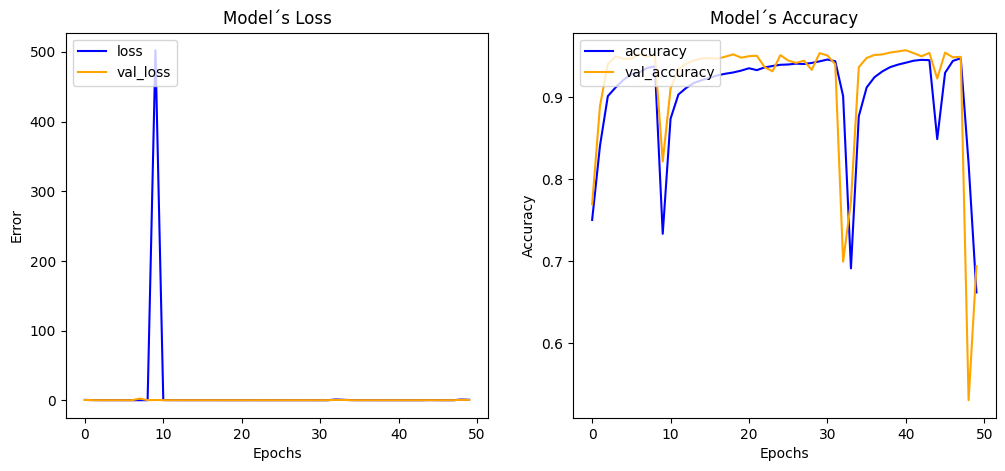

In [73]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Model´s Loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model´s Accuracy')
plt.legend(loc='upper left')
plt.show()

In [74]:
model.load_weights("/kaggle/working/mejor_modelo.keras")
predictions = model.predict(inputs_test)


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


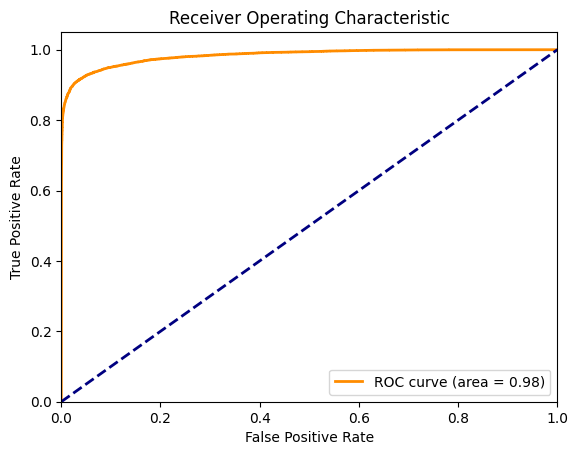

In [75]:
probabilities = predictions

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test.values, probabilities)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [76]:
Youden_index = tpr - fpr
optimal_threshold_index = np.argmax(Youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print("Umbral óptimo según el índice Youden:", optimal_threshold)

Umbral óptimo según el índice Youden: 0.6377699


In [77]:
binary_predictions = (predictions > optimal_threshold).astype(int)
results = []
print(binary_predictions)
print(y_test.values)
for element in binary_predictions:
    results.append(element[0])
accuracy = np.mean(results ==y_test.values)
from sklearn.metrics import confusion_matrix
#matriz de confusión
cm1 = confusion_matrix(y_test.values, results)
TP = cm1[1, 1]
FP = cm1[0, 1]
TN = cm1[0, 0]
FN = cm1[1, 0]
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Matriz de Confusión:")
print(cm1)
print("Especificidad (Specificity):", specificity)
print("Sensibilidad (Sensitivity):", sensitivity)
print("Accuracy:", accuracy)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[1 1 1 ... 1 1 1]
Matriz de Confusión:
[[18318   686]
 [ 1436 15459]]
Especificidad (Specificity): 0.963902336350242
Sensibilidad (Sensitivity): 0.9150044391831903
Accuracy: 0.9408897183765564


## 2.6 HYPERPARAMETER LSTM

In [18]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Input(shape=(32, 39)))

    # First LSTM layer with larger range of units
    model.add(LSTM(units=hp.Int('lstm_units_0', min_value=128, max_value=256, step=128),
                   activation=hp.Choice('activation_0', ['relu', 'tanh']),
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_rate_0', min_value=0.0, max_value=0.5, step=0.25)))

    # Intermediate LSTM layers
    num_lstm_layers = hp.Int('num_lstm_layers', 1, 3)
    for i in range(1, num_lstm_layers + 1):
        model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=64, max_value=128, step=32),
                       activation=hp.Choice(f'activation_{i}', ['relu', 'tanh']),
                       return_sequences=True))
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    # Last LSTM layer with smaller range of units
    model.add(LSTM(units=hp.Int(f'lstm_units_{num_lstm_layers + 1}', min_value=32, max_value=64, step=32),
                   activation=hp.Choice(f'activation_{num_lstm_layers + 1}', ['relu', 'tanh']),
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float(f'dropout_rate_{num_lstm_layers + 1}', min_value=0.0, max_value=0.5, step=0.25)))
    
    model.add(Flatten())

    # Dense layers
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=32)))
    model.add(Dense(units=hp.Int('dense_units1', min_value=32, max_value=64, step=32)))
    model.add(Dropout(rate=hp.Float('dropout_rate_dense', min_value=0.0, max_value=0.5, step=0.25)))

    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning1'
)

# Set up the checkpoint callback
checkpoint = ModelCheckpoint("/kaggle/working/mejor_modelo_LSTM.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define the search space for batch_size outside the model function
batch_size = kt.HyperParameters().Int('batch_size', 128, 256, step=128)

# Custom callback to stop training if accuracy is below 0.8 after 3 epochs
class EarlyStoppingAtMinAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.8, patience=3):
        super(EarlyStoppingAtMinAccuracy, self).__init__()
        self.monitor = monitor
        self.value = value
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if current < self.value:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
        else:
            self.wait = 0

# EarlyStopping callback for general early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

# Run the search for the best hyperparameters
tuner.search(inputs, y_train, epochs=10, validation_data=(inputs_val, y_val),
             callbacks=[checkpoint, early_stopping, EarlyStoppingAtMinAccuracy()],
             batch_size=batch_size)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 20 Complete [00h 01m 36s]
val_accuracy: 0.7633383274078369

Best val_accuracy So Far: 0.9576815962791443
Total elapsed time: 01h 48m 23s


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 256)        │       303,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,257 (1.86 MB)

 Trainable params: 488,257 (1.86 MB)

 Non-trainable params: 0 (0.00 B)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |256               |lstm_units_0
relu              |relu              |activation_0
0                 |0                 |dropout_rate_0
2                 |2                 |num_lstm_layers
128               |128               |lstm_units_1
relu              |relu              |activation_1
0.4               |0.4               |dropout_rate_1
64                |64                |lstm_units_2
tanh              |tanh              |activation_2
0.25              |0.25              |dropout_rate_2
96                |96                |dense_units
0.5               |0.5               |dropout_rate_dense
0.0039229         |0.0039229         |learning_rate

Epoch 1/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7556 - loss: 0.4431
Epoch 1: val_accuracy improved from -inf to 0.92115, saving model to /kaggle/working/mejor_modelo_LSTM.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 79s 102ms/step -

In [19]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 256)        │       303,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 96)         │       135,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 488,257 (1.86 MB)

 Trainable params: 488,257 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
checkpoint = ModelCheckpoint("/kaggle/working/mejor_modelo_lstm.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
opt = Adam(learning_rate=1e-3)
best_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
#Train our model
hist_LSTM = best_model.fit(inputs, y_train, epochs=50, validation_data=(inputs_val, y_val), callbacks=[checkpoint], batch_size = 128)

Epoch 1/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9726 - loss: 0.0692
Epoch 1: val_accuracy improved from -inf to 0.94793, saving model to /kaggle/working/mejor_modelo_lstm.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.9726 - loss: 0.0692 - val_accuracy: 0.9479 - val_loss: 0.1593
Epoch 2/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9795 - loss: 0.0544
Epoch 2: val_accuracy improved from 0.94793 to 0.95243, saving model to /kaggle/working/mejor_modelo_lstm.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.9795 - loss: 0.0544 - val_accuracy: 0.9524 - val_loss: 0.1695
Epoch 3/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9815 - loss: 0.0479
Epoch 3: val_accuracy improved from 0.95243 to 0.95490, saving model to /kaggle/working/mejor_modelo_lstm.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9815 - loss: 0.0479 - val_accuracy: 0.9549 - val_loss: 0.1760
Epoch 4/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/s

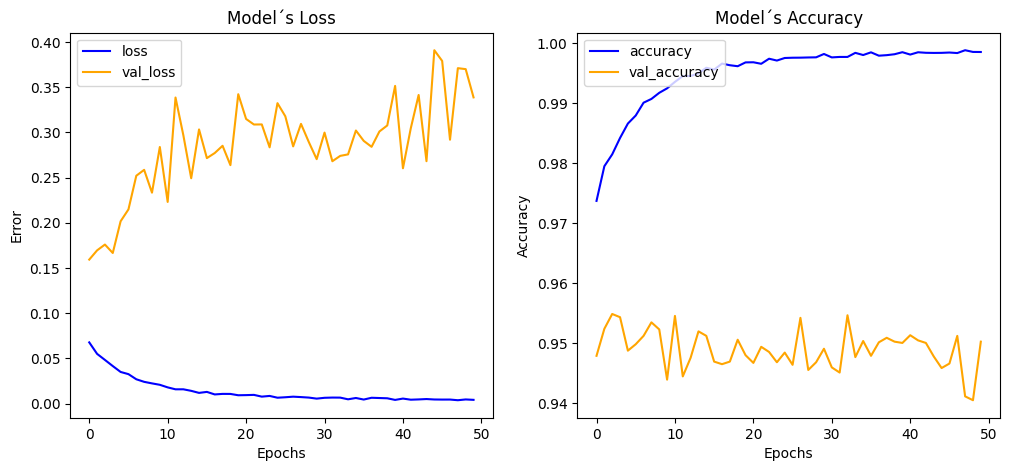

In [22]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_LSTM.history['loss'], color='blue', label='loss')
plt.plot(hist_LSTM.history['val_loss'], color='orange', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Model´s Loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist_LSTM.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist_LSTM.history['val_accuracy'], color='orange', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model´s Accuracy')
plt.legend(loc='upper left')
plt.show()

In [25]:
best_model.load_weights("/kaggle/working/mejor_modelo_lstm.keras")
predictions = best_model.predict(inputs_test)

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step


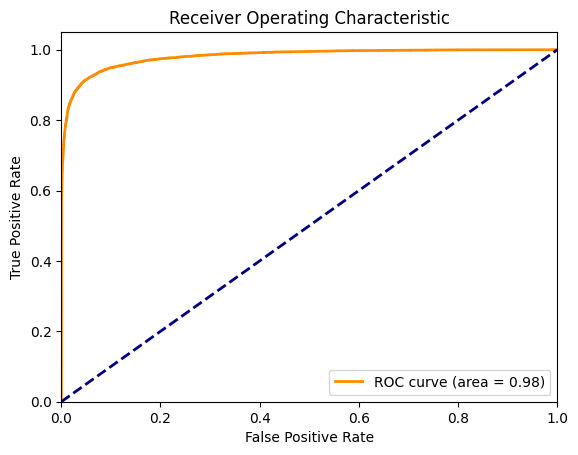

In [26]:
probabilities = predictions

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test.values, probabilities)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
Youden_index = tpr - fpr
optimal_threshold_index = np.argmax(Youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print("Umbral óptimo según el índice Youden:", optimal_threshold)

Umbral óptimo según el índice Youden: 0.7698299


In [28]:
binary_predictions = (predictions > optimal_threshold).astype(int)
results = []
print(binary_predictions)
print(y_test.values)
for element in binary_predictions:
    results.append(element[0])
accuracy = np.mean(results ==y_test.values)
from sklearn.metrics import confusion_matrix
#matriz de confusión
cm1 = confusion_matrix(y_test.values, results)
TP = cm1[1, 1]
FP = cm1[0, 1]
TN = cm1[0, 0]
FN = cm1[1, 0]
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Matriz de Confusión:")
print(cm1)
print("Especificidad (Specificity):", specificity)
print("Sensibilidad (Sensitivity):", sensitivity)
print("Accuracy:", accuracy)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[1 1 1 ... 1 1 1]
Matriz de Confusión:
[[18076   928]
 [ 1448 15447]]
Especificidad (Specificity): 0.9511681751210271
Sensibilidad (Sensitivity): 0.9142941698727434
Accuracy: 0.9338143123763893


## 2.7 CNN-LSTM

### 2.7.1 NO HYPERPARAMETER SELECTION

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Dropout, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Definir la arquitectura del modelo
model1 = Sequential()

# Primera etapa: CNN
model1.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(32, 39)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(BatchNormalization())
model1.add(LeakyReLU(negative_slope=0.01))
model1.add(Dropout(0.5))

model1.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(32, 39)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(BatchNormalization())
model1.add(LeakyReLU(negative_slope=0.01))
model1.add(Dropout(0.5))



# Segunda etapa: LSTM
model1.add(LSTM(128, activation='relu', return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(64, activation='relu', return_sequences=True))
model1.add(Dropout(0.2))

model1.add(LSTM(32, activation='relu', return_sequences=True))
model1.add(Dropout(0.2))

model1.add(Flatten())


# Capa completamente conectada
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))

# Capa de salida
model1.add(Dense(1, activation='sigmoid'))

# Resumen del modelo
model1.summary()
#Have the best model saved
checkpoint = ModelCheckpoint("/kaggle/working/mejor_modelo1.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
opt = Adam(learning_rate=1e-3)
model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
#Train our model
hist1 = model1.fit(inputs, y_train, epochs=150, validation_data=(inputs_val, y_val), callbacks=[checkpoint], batch_size = 128)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 30, 256)        │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 13, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 6, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 6, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 6, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,049 (1.29 MB)

 Trainable params: 337,281 (1.29 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/150
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7585 - loss: 0.4597
Epoch 1: val_accuracy improved from -inf to 0.86480, saving model to /kaggle/working/mejor_modelo1.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.7586 - loss: 0.4596 - val_accuracy: 0.8648 - val_loss: 0.2715
Epoch 2/150
709/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8736 - loss: 0.2691
Epoch 2: val_accuracy improved from 0.86480 to 0.86715, saving model to /kaggle/working/mejor_modelo1.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8737 - loss: 0.2691 - val_accuracy: 0.8672 - val_loss: 0.2892
Epoch 3/150
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8877 - loss: 0.2425
Epoch 3: val_accuracy improved from 0.86715 to 0.90176, saving model to /kaggle/working/mejor_modelo1.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8877 - loss: 0.2425 - val_accuracy: 0.9018 - val_loss: 0.2237
Epoch 4/150
708/713 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

In [38]:
print("Hola")

Hola


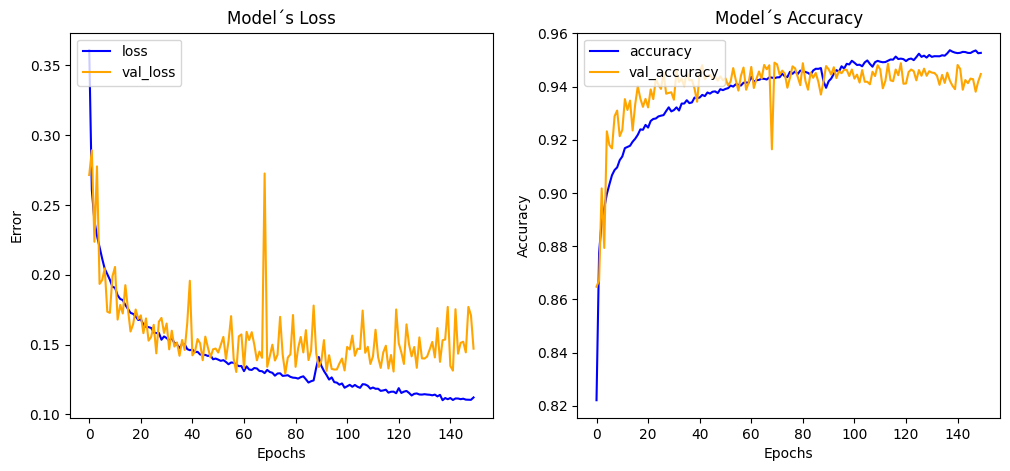

In [39]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist1.history['loss'], color='blue', label='loss')
plt.plot(hist1.history['val_loss'], color='orange', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Model´s Loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist1.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist1.history['val_accuracy'], color='orange', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model´s Accuracy')
plt.legend(loc='upper left')
plt.show()


In [40]:
model1.load_weights("/kaggle/working/mejor_modelo1.keras")
predictions = model1.predict(inputs_test)


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


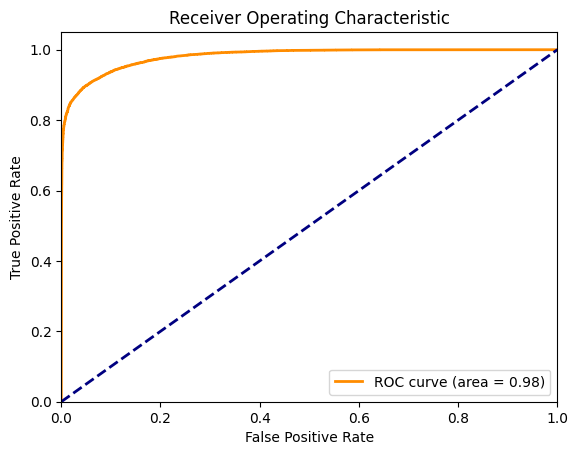

Umbral óptimo según el índice Youden: 0.6701771


In [41]:
probabilities = predictions

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test.values, probabilities)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
Youden_index = tpr - fpr
optimal_threshold_index = np.argmax(Youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print("Umbral óptimo según el índice Youden:", optimal_threshold)

In [42]:
binary_predictions = (predictions > optimal_threshold).astype(int)
results = []
print(binary_predictions)
print(y_test.values)
for element in binary_predictions:
    results.append(element[0])
accuracy = np.mean(results ==y_test.values)
from sklearn.metrics import confusion_matrix
#matriz de confusión
cm1 = confusion_matrix(y_test.values, results)
TP = cm1[1, 1]
FP = cm1[0, 1]
TN = cm1[0, 0]
FN = cm1[1, 0]
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Matriz de Confusión:")
print(cm1)
print("Especificidad (Specificity):", specificity)
print("Sensibilidad (Sensitivity):", sensitivity)
print("Accuracy:", accuracy)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[1 1 1 ... 1 1 1]
Matriz de Confusión:
[[18075   929]
 [ 1738 15157]]
Especificidad (Specificity): 0.95111555462008
Sensibilidad (Sensitivity): 0.8971293282036106
Accuracy: 0.9257082369982451


### 2.7.2 CNN-LSTM WITH HYPERPARAMETER SELECTION

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Dropout, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import numpy as np
from keras.callbacks import ModelCheckpoint

def build_model(hp):
    model = Sequential()
    
    # Number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3, step=1)
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv1D(filters=hp.Int(f'conv{str(i+1)}_filters', min_value=32, max_value=256, step=32),
                             kernel_size= 3,
                             activation='relu', input_shape=(32, 39)))
        else:
            model.add(Conv1D(filters=hp.Int(f'conv{str(i+1)}_filters', min_value=32, max_value=256, step=32),
                             kernel_size=3,
                             activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dropout(0.2))
    
    # Number of LSTM layers
    num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=4, step=1)
    
    # Add LSTM layers
    for i in range(num_lstm_layers):
        model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                       activation='relu',
                       return_sequences=True if i < num_lstm_layers - 1 else False))
        model.add(Dropout(0.2))
    
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=128, step=32), activation='relu'))
    model.add(Dense(units=int(hp.Int('dense_units', min_value=32, max_value=64, step=32)/2), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='keras_tuner_dir2',
    project_name='my_cnn_lstm_model2'
)

# Perform the hyperparameter search
tuner.search(inputs, y_train, epochs=30, validation_data=(inputs_val, y_val), callbacks=[ModelCheckpoint("mejor_modelo_xd.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
             , batch_size=128, verbose = 2)



# Summary of the best model found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps}")

tuner.results_summary()

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

Trial 30 Complete [00h 01m 57s]
val_accuracy: 0.9375401735305786

Best val_accuracy So Far: 0.9460038542747498
Total elapsed time: 01h 23m 04s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7edccd3b3040>
Results summary
Results in keras_tuner_dir2/my_cnn_lstm_model2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 26 summary
Hyperparameters:
num_conv_layers: 1
conv1_filters: 64
num_lstm_layers: 4
lstm_units_0: 128
dense_units: 64
learning_rate: 0.001
conv2_filters: 256
lstm_units_1: 64
lstm_units_2: 32
conv3_filters: 224
lstm_units_3: 64
Score: 0.9460038542747498

Trial 20 summary
Hyperparameters:
num_conv_layers: 2
conv1_filters: 64
num_lstm_layers: 4
lstm_units_0: 128
dense_units: 128
learning_rate: 0.001
conv2_filters: 128
lstm_units_1: 64
lstm_units_2: 64
conv3_filters: 96
lstm_units_3: 128
Score: 0.9424684047698975

Trial 24 summary
Hyperparameters:
num_conv_layers: 2
conv1_filters: 64
num_lstm

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [44]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,553 (779.50 KB)

 Trainable params: 199,425 (779.00 KB)

 Non-trainable params: 128 (512.00 B)

In [45]:
checkpoint = ModelCheckpoint("/kaggle/working/mejor_modelo_CNN_LSTM.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
opt = Adam(learning_rate=1e-3)
model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
#Train our model
hist_best = best_model.fit(inputs, y_train, epochs=150, validation_data=(inputs_val, y_val), callbacks=[checkpoint], batch_size = 128)

Epoch 1/150
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9576 - loss: 0.1020
Epoch 1: val_accuracy improved from -inf to 0.94043, saving model to /kaggle/working/mejor_modelo_CNN_LSTM.keras
713/713 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.9576 - loss: 0.1020 - val_accuracy: 0.9404 - val_loss: 0.1586
Epoch 2/150
711/713 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9579 - loss: 0.1018
Epoch 2: val_accuracy did not improve from 0.94043
713/713 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9579 - loss: 0.1018 - val_accuracy: 0.9296 - val_loss: 0.2215
Epoch 3/150
711/713 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9600 - loss: 0.0964
Epoch 3: val_accuracy did not improve from 0.94043
713/713 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9600 - loss: 0.0964 - val_accuracy: 0.9379 - val_loss: 0.1894
Epoch 4/150
709/713 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9619 - loss: 0.0906
Epoch 4: val_accuracy improved from 0.94043 to 0.94375, saving model to /kaggl

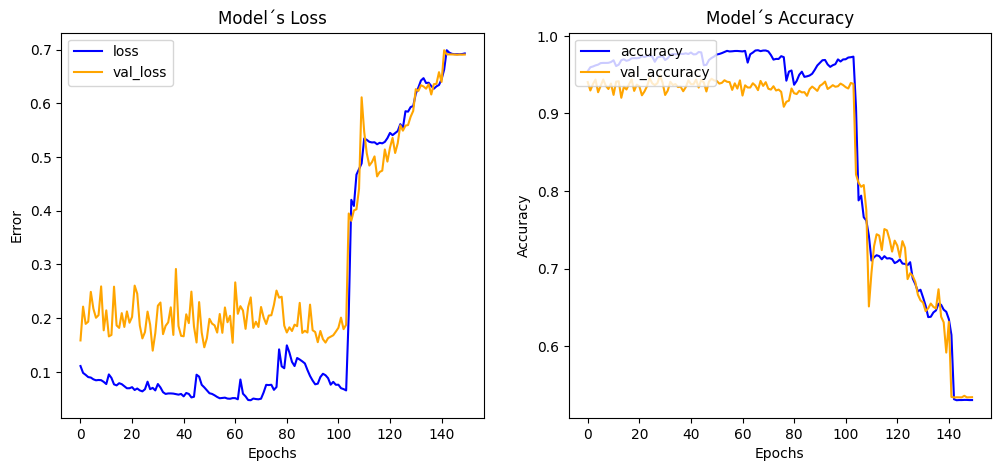

In [46]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_best.history['loss'], color='blue', label='loss')
plt.plot(hist_best.history['val_loss'], color='orange', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Model´s Loss')
plt.legend(loc='upper left')

plt.subplot(1,2,2)
plt.plot(hist_best.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist_best.history['val_accuracy'], color='orange', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model´s Accuracy')
plt.legend(loc='upper left')
plt.show()

In [47]:
best_model.load_weights("/kaggle/working/mejor_modelo_CNN_LSTM.keras")
predictions = best_model.predict(inputs_test)

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


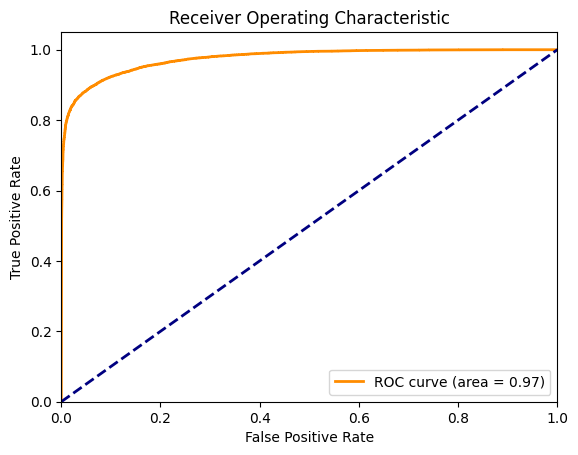

In [48]:
probabilities = predictions

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test.values, probabilities)

# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [49]:
Youden_index = tpr - fpr
optimal_threshold_index = np.argmax(Youden_index)
optimal_threshold = thresholds[optimal_threshold_index]

print("Umbral óptimo según el índice Youden:", optimal_threshold)

Umbral óptimo según el índice Youden: 0.67515135


In [50]:
binary_predictions = (predictions > optimal_threshold).astype(int)
results = []
print(binary_predictions)
print(y_test.values)
for element in binary_predictions:
    results.append(element[0])
accuracy = np.mean(results ==y_test.values)
from sklearn.metrics import confusion_matrix
#matriz de confusión
cm1 = confusion_matrix(y_test.values, results)
TP = cm1[1, 1]
FP = cm1[0, 1]
TN = cm1[0, 0]
FN = cm1[1, 0]
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("Matriz de Confusión:")
print(cm1)
print("Especificidad (Specificity):", specificity)
print("Sensibilidad (Sensitivity):", sensitivity)
print("Accuracy:", accuracy)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[1 1 1 ... 1 1 1]
Matriz de Confusión:
[[17977  1027]
 [ 1886 15009]]
Especificidad (Specificity): 0.9459587455272574
Sensibilidad (Sensitivity): 0.8883693400414324
Accuracy: 0.9188556784311541
